In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
import os
import xrmreader
import dxchange
from cil.io import ZEISSDataReader
from cil.processors import Binner, TransmissionAbsorptionConverter
from cil.recon import FDK
from cil.framework import AcquisitionGeometry, ImageData, AcquisitionData

astropy module not found


### Utilities and Change of Class functions

In [2]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

### Need to change the `read` method of `ZEISSDataReader`
- See discussion in [PR 1605](https://github.com/TomographicImaging/CIL/issues/1605) in CIL.

In [3]:
def revert_shifts(projections, x_shifts, y_shifts):
    '''

    :param projections: projection data
    :param x_shifts: x shift parameter per projection
    :param y_shifts: y shift parameter per projection
    :return: shift corrected porjections
    '''
    num_projections, img_size_x, img_size_y = projections.shape
    shifts = np.zeros((num_projections, 2))
    shifts[:, 0] = x_shifts
    shifts[:, 1] = y_shifts

    # shift each projection
    for i in range(num_projections):
        # input is extended by repeating its last value to avoid zeros after cropping
        projections[i, :, :] = shift(projections[i, :, :], (shifts[i, 1], shifts[i, 0]), order=1, mode='nearest')

    return projections


def new_read(self):
        
    '''
    Reads projections and return Acquisition (TXRM) or Image (TXM) Data container
    '''
    # Load projections or slices from file
    slice_range = None
    if self._roi:
        slice_range = tuple(self._roi)
    data, _ = dxchange.read_txrm(self.file_name,slice_range)

    if isinstance(self._geometry,AcquisitionGeometry):
        # Normalise data by flatfield
        data = data / self._metadata['reference']        
        data = revert_shifts(data, self._metadata["x-shifts"], self._metadata["y-shifts"])      
        acq_data = AcquisitionData(array=data, deep_copy=False, geometry=self._geometry.copy(),suppress_warning=True)
        return acq_data
    else:
        ig_data = ImageData(array=data, deep_copy=False, geometry=self._geometry.copy())
        return ig_data
    
ZEISSDataReader.read = new_read

### Path to Datasets

In [4]:
path = r'Z:\Users\Antony\RSIF\microct\raw\20231012_VERSA_3666_AV\20231012_VERSA_3666_AV_2023-10-12_175019\battery_scout_bin2'
path = r"D:\AV\Finden Dropbox\Finden_Research\Active_Projects\RSIF\BIL\data\BIL\20231012_VERSA_3666_AV_battery_ROI_40s"

filename_sinogram = os.path.join(path, "20231012_VERSA_3666_AV_battery_scout_bin2.txrm")
filename_recon = os.path.join(path, "20231012_VERSA_3666_AV_battery_scout_bin2_recon.txm")



### Read and show Metadata keys

In [5]:
metadata = xrmreader.read_metadata(filename_sinogram)

for key in metadata.keys():    
    if isinstance(metadata[key], np.ndarray):
        print(key + " = ", metadata[key][0:10])
    else:
        print(key + " = ", metadata[key])

facility =  None
image_width =  1024
image_height =  1024
data_type =  5
number_of_images =  801
pixel_size =  9.005288124084473
reference_exposure_time =  0.6494985818862915
reference_current =  71.64067840576172
reference_voltage =  139.844970703125
reference_data_type =  10
image_data_type =  5
thetas =  [-3.14153167 -3.13380317 -3.12595484 -3.11809425 -3.11024725 -3.10239891
 -3.09452501 -3.08667135 -3.07882594 -3.07098346]
x-shifts =  [-0.02338324 -8.31449032  3.44475412  7.60942364  4.46493196  1.39798403
  6.30554199 -0.50505334 -2.10339952  9.3211956 ]
y-shifts =  [-0.06622199 -0.95438933  2.88818741  0.95634484 -2.7804389   0.52345252
 -1.7584523  -1.91345716  2.86733198 -0.94697839]
AMC-x-shifts =  [-0.03012854 -0.02821015 -0.02629176 -0.02437337 -0.02245498 -0.02053659
 -0.0186182  -0.01669981 -0.01478142 -0.01286303]
AMC-y-shifts =  [0.10338005 0.10249254 0.10160504 0.10071754 0.09983003 0.09894253
 0.09805502 0.09716751 0.09628001 0.09539251]
temperature-x-shifts =  [-0.07

### Load Reconstruction from Zeiss

In [6]:
reader = ZEISSDataReader()
reader.set_up(file_name=filename_recon)
recon = reader.read()

c:\Users\anton\anaconda3\envs\bil\Lib\site-packages\cil\framework\data_container.py:112: UserWarning: Over-riding geometry.dtype with data.dtype
  warnings.warn("Over-riding geometry.dtype with data.dtype", UserWarning)


### Load raw sinogram data 

In [7]:
reader = ZEISSDataReader()
reader.set_up(file_name=filename_sinogram)
sinogram = reader.read()

C:\Users\anton\AppData\Local\Temp\ipykernel_19364\1598137733.py:37: UserWarning: Unused keyword arguments: {'suppress_warning': True}
  acq_data = AcquisitionData(array=data, deep_copy=False, geometry=self._geometry.copy(),suppress_warning=True)


### Preprocessing

In [8]:
absorb = TransmissionAbsorptionConverter()
absorb.set_input(sinogram)
data_absorbed = absorb.get_output()
data_absorbed -= np.mean(data_absorbed.array[0:10, :, 0:10])
data_absorbed.reorder('tigre')

### Compute offset 

In [9]:
center_shift = metadata["center_shift"]
print("center shift is {}".format(center_shift))

sdd = np.abs(metadata["source_isocenter_distance"]) + np.abs(metadata["detector_isocenter_distance"])
sod = metadata["source_isocenter_distance"]

### formula center_shift * metadata["pixel_size"]/1000
object_offset = -center_shift * metadata["pixel_size"]/1000

print("object_offset is {}".format(object_offset))

center shift is 0.8091099262237549
object_offset is -0.007286268009701643


### Correct CIL Geometry for offset and Reconstruct

In [10]:
data_absorbed.geometry.config.system.rotation_axis.position = [object_offset, 0, 0]
data_absorbed.geometry.config.system.source.position = [0, sod, 0]
data_absorbed.geometry.config.system.detector.position = [0, metadata["detector_isocenter_distance"], 0]

ig = data_absorbed.geometry.get_ImageGeometry()
ig.voxel_num_z = 1017
ig.voxel_num_x = 1004


In [11]:
fbp_recon = FDK(data_absorbed, ig).run()

FDK recon

Input Data:
	angle: 801
	vertical: 1024
	horizontal: 1024

Reconstruction Volume:
	vertical: 1017
	horizontal_y: 1024
	horizontal_x: 1004

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



In [12]:
num_slice = 600

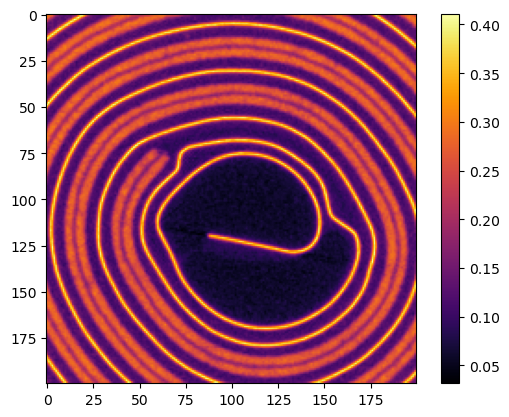

In [13]:
plt.figure()
plt.imshow(fbp_recon.array[num_slice,400:600,400:600], cmap="inferno")
plt.colorbar()
plt.show()


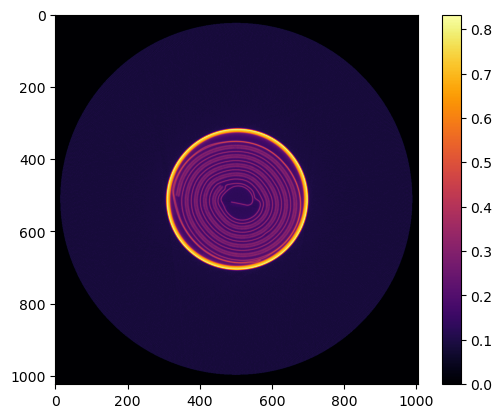

In [14]:
img = np.flip(np.array(recon.array[num_slice], dtype="float32")/2**16, axis=0)

plt.figure()
plt.imshow(img, cmap="inferno")
plt.colorbar()
plt.show()


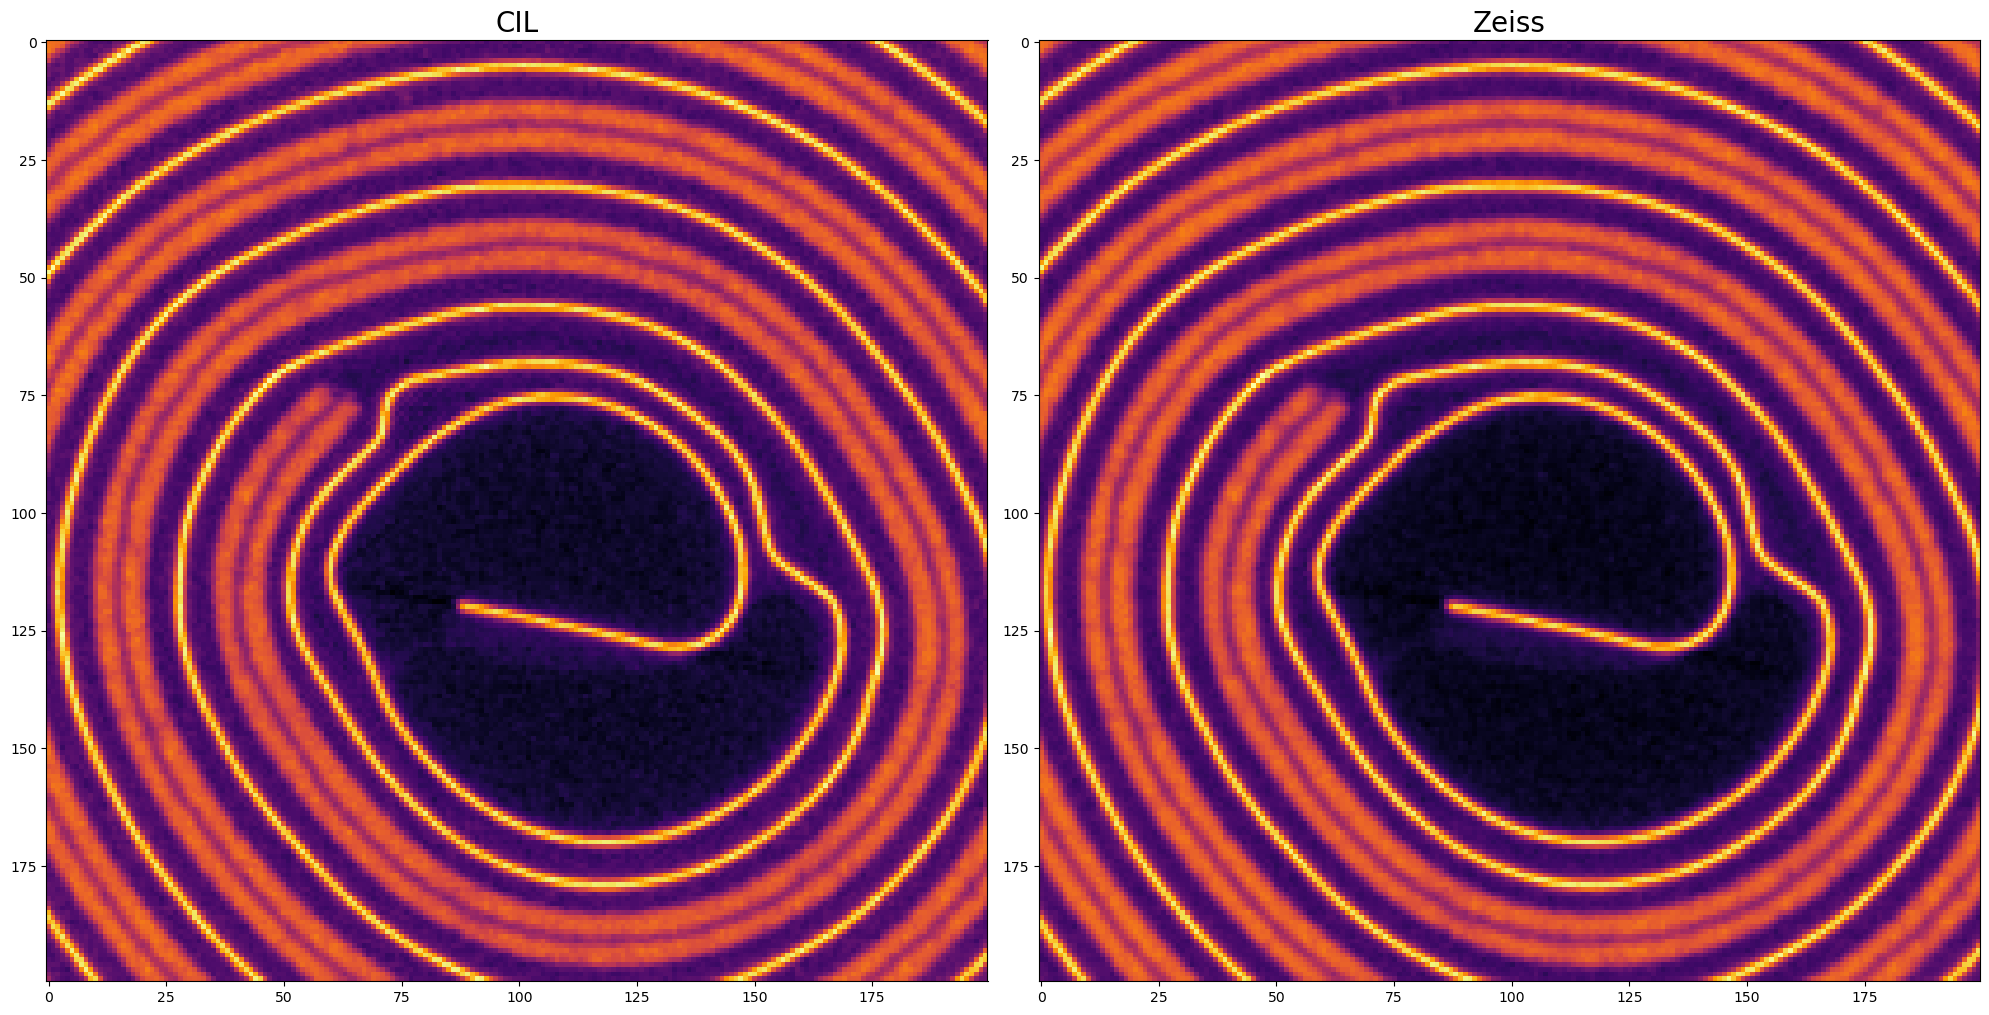

In [15]:

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(fbp_recon.array[num_slice,400:600,400:600], cmap="inferno")
axs[0].set_title('CIL', fontsize=20)

axs[1].imshow(img[400:600,400:600], cmap="inferno")
axs[1].set_title('Zeiss', fontsize=20)

plt.tight_layout()
# plt.subplots_adjust(wspace=-0.6, hspace=0.2)

# plt.savefig("cil_vs_zeiss_roi_recon.png")
plt.show()

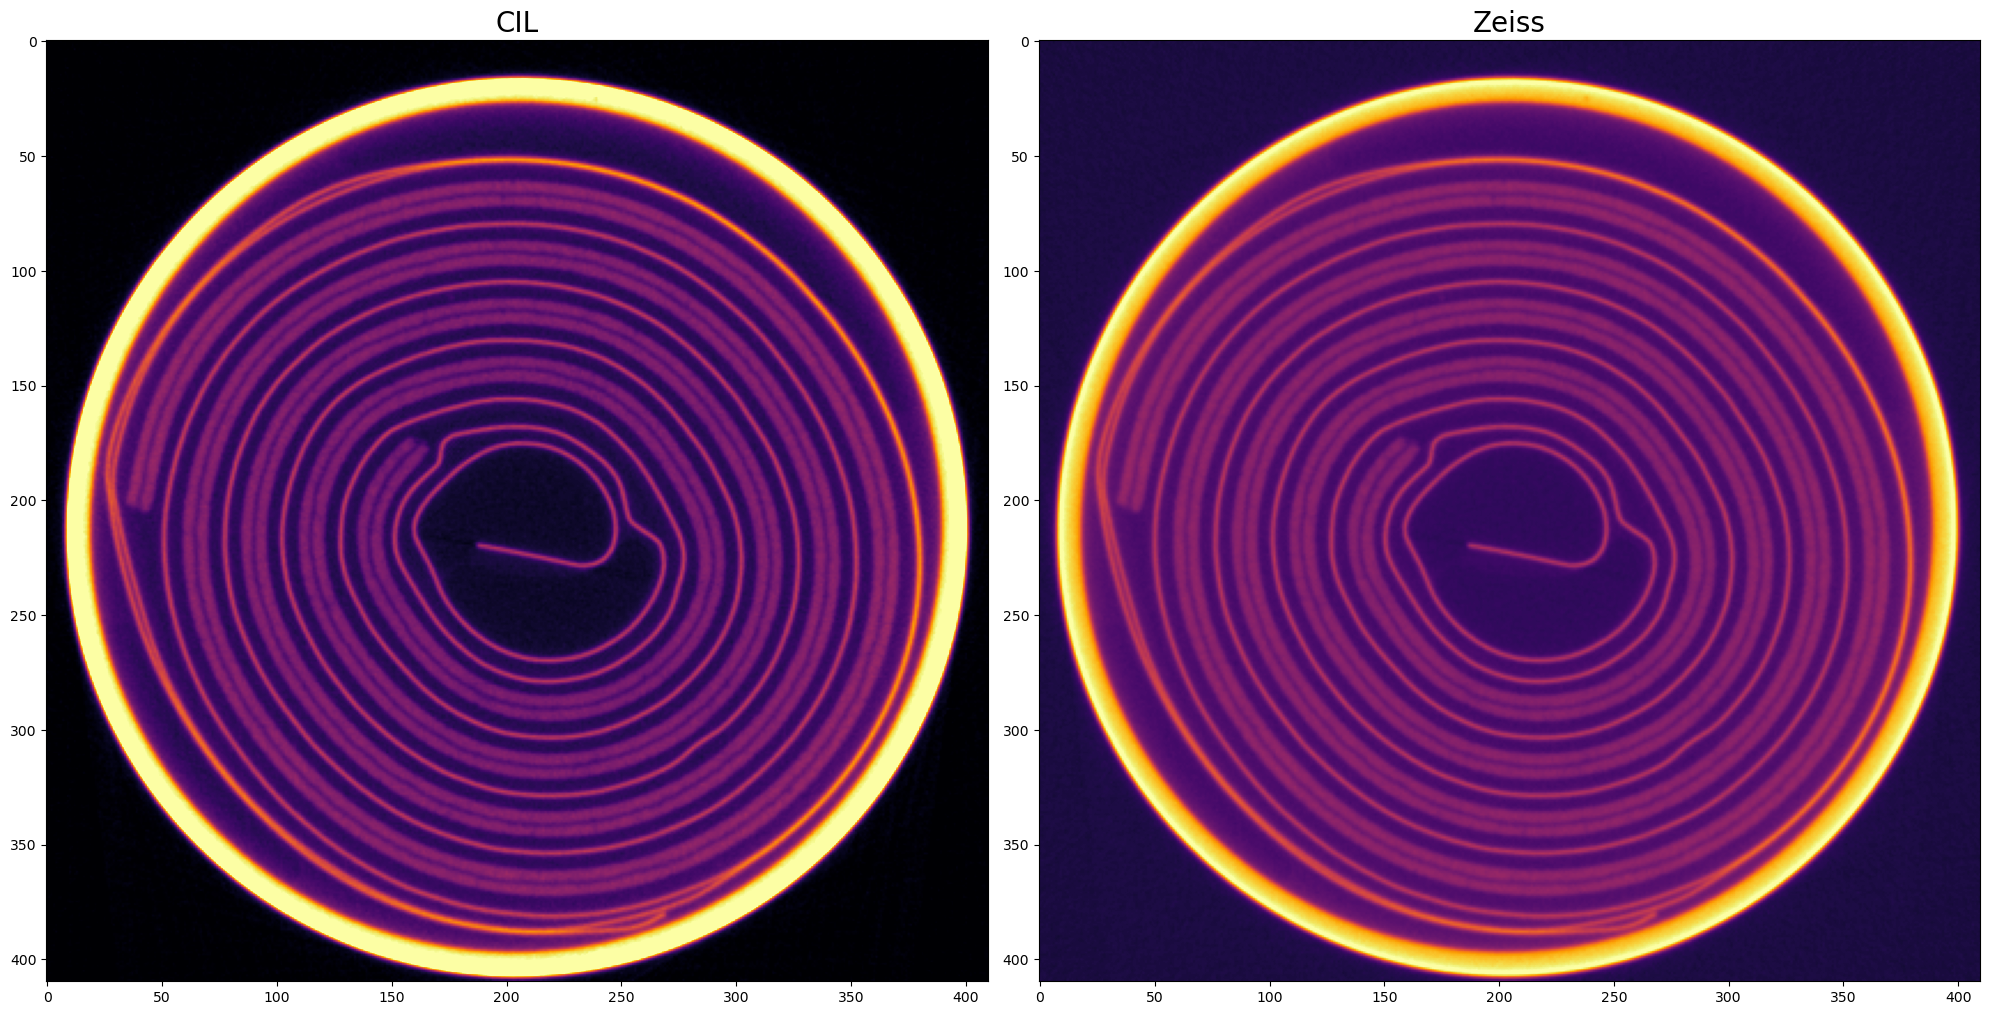

In [16]:

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(fbp_recon.array[num_slice,300:710,300:710], cmap="inferno", vmin=0, vmax=0.8)
axs[0].set_title('CIL', fontsize=20)

axs[1].imshow(img[300:710,300:710], cmap="inferno", vmin=0, vmax=0.8)
axs[1].set_title('Zeiss', fontsize=20)

plt.tight_layout()
# plt.subplots_adjust(wspace=-0.6, hspace=0.2)
# plt.savefig("cil_vs_zeiss_roi_recon.png")
plt.show()